# Import Modules

In [85]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim

import utils

In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare Data

In [87]:
source_X, target_X, source_y_task, target_y_task, x_grid, x1_grid, x2_grid = utils.get_source_target_from_make_moons()
source_loader, target_loader, source_y_task, source_X, target_X, target_y_task = utils.get_loader(source_X, target_X, source_y_task, target_y_task)

# Instantiate Feature Extractor, Domain Classifier, Task Classifier

In [88]:
hidden_size = 10
num_domains = 1
num_classes = 1
dropout_ratio = 0.5

feature_extractor = utils.Encoder(input_size=source_X.shape[1], output_size=hidden_size).to(device)
domain_classifier = utils.Decoder(input_size=hidden_size, output_size=num_domains).to(device)
task_classifier = utils.Decoder(input_size=hidden_size, output_size=num_classes).to(device)

In [89]:
learning_rate = 0.001

criterion = nn.BCELoss()
feature_optimizer = optim.Adam(feature_extractor.parameters(), lr=learning_rate)
domain_optimizer = optim.Adam(domain_classifier.parameters(), lr=learning_rate)
task_optimizer = optim.Adam(task_classifier.parameters(), lr=learning_rate)

# Domain Invariant Learning

In [90]:
num_epochs = 1000

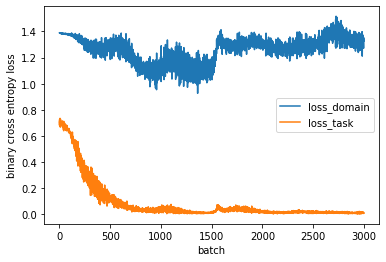

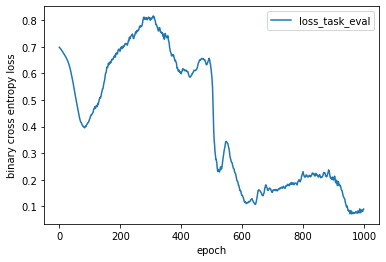

In [91]:
feature_extractor, task_classifier = utils.fit(source_loader, target_loader, target_X, target_y_task,
                                               feature_extractor, domain_classifier, task_classifier, criterion,
                                               feature_optimizer, domain_optimizer, task_optimizer, num_epochs=num_epochs)

# Domain Adaptation Accuracy

In [92]:
target_feature_eval = feature_extractor(target_X)
pred_y_task = task_classifier(target_feature_eval)
pred_y_task = torch.sigmoid(pred_y_task).reshape(-1)
pred_y_task = pred_y_task > 0.5

acc = sum(pred_y_task == target_y_task) / target_y_task.shape[0]
print(f"Accuracy:{acc}")

Accuracy:0.9599999785423279


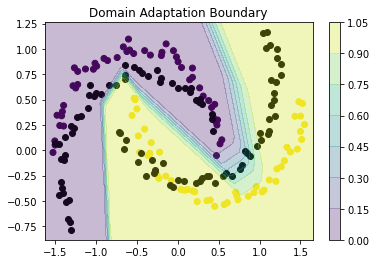

In [93]:
source_X = source_X.cpu()
target_X = target_X.cpu()

x_grid = torch.tensor(x_grid, dtype=torch.float32)
x_grid = x_grid.to(device)

x_grid_feature = feature_extractor(x_grid.T)
y_grid = task_classifier(x_grid_feature)
y_grid = torch.sigmoid(y_grid)
y_grid = y_grid.cpu().detach().numpy()

plt.title("Domain Adaptation Boundary")
plt.scatter(source_X[:, 0], source_X[:, 1], c=source_y_task)
plt.scatter(target_X[:, 0], target_X[:, 1], c="black")
plt.contourf(x1_grid, x2_grid, y_grid.reshape(100, 100), alpha=0.3)
plt.colorbar()

# Without Adaptation

In [94]:
task_classifier = utils.Decoder(input_size=source_X.shape[1], output_size=num_classes).to(device)
task_optimizer = optim.Adam(task_classifier.parameters(), lr=learning_rate)

In [95]:
task_classifier = utils.fit_without_adaptation(source_loader, task_classifier, task_optimizer, criterion, num_epochs)

In [96]:
pred_y_task = task_classifier(target_X.to(device))
pred_y_task = torch.sigmoid(pred_y_task).reshape(-1)
pred_y_task = pred_y_task > 0.5
acc = sum(pred_y_task == target_y_task) / target_y_task.shape[0]
print(f"Without Adaptation Accuracy:{acc}")

Without Adaptation Accuracy:0.8299999833106995


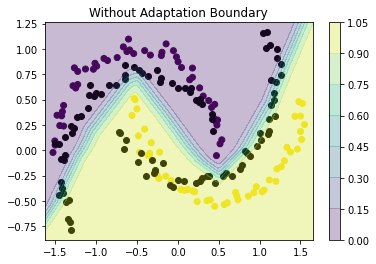

In [97]:
y_grid = task_classifier(x_grid.T)
y_grid = torch.sigmoid(y_grid)
y_grid = y_grid.cpu().detach().numpy()

plt.title("Without Adaptation Boundary")
plt.scatter(source_X[:, 0], source_X[:, 1], c=source_y_task)
plt.scatter(target_X[:, 0], target_X[:, 1], c="black")
plt.contourf(x1_grid, x2_grid, y_grid.reshape(100, 100), alpha=0.3)
plt.colorbar()

# t-SNE Visualization for Extracted Feature

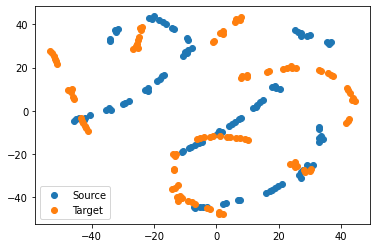

In [98]:
target_feature_eval = target_feature_eval.cpu().detach().numpy()
source_feature = feature_extractor(source_X.to(device))
source_feature = source_feature.cpu().detach().numpy()
    
utils.visualize_tSNE(target_feature_eval, source_feature)